# <center><u>**Los Ángeles**<u><center>
<center><img src="https://static.dezeen.com/uploads/2017/03/los-angeles-skyline-2030-visualhouse_dezeen_hero.jpg" alt="drawing" width="1200"/><center>

In [1]:
# IMPORTO LAS LIBRERÍAS NECESARIAS

import numpy as np
import pandas as pd
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
import plotly_express as px

import os
import json
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# mapas interactivos
import folium
from folium.plugins import FastMarkerCluster
#import geopandas as gpd
import pygeoj # para leer archivos geojson
from branca.colormap import LinearColormap

#to make the plotly graphs
import plotly.graph_objs as go
import chart_studio.plotly as py
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)

#text mining
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import re
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from wordcloud import WordCloud

In [2]:
"""# DESCARGAMOS ARCHIVOS

# Creamos carpeta
!mkdir input/
# Descargar archivo listings_details.csv
!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/data/listings.csv.gz -P input/ \
    && gunzip input/listings.csv \
    && mv input/listings.csv input/listings_details.csv
# Descargar archivo reviews_details.csv
!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/data/calendar.csv.gz -P input/ \
    && gunzip input/calendar.csv \
    && mv input/calendar.csv input/calendar.csv
# Descargar archivo calendar.csv
!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/data/reviews.csv.gz -P input/ \
    && gunzip input/reviews.csv
# ¿Sabrías descargar el resto de archivos?
!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/visualisations/neighbourhoods.csv -P input/ \
    && gunzip input/neighbourhoods.csv

!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/visualisations/neighbourhoods.geojson -P input/ \
    && gunzip input/neighbourhoodsgeojson.csv

!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/visualisations/listings.csv -P input/ \
    && gunzip input/listings_sumary.csv

!wget http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/visualisations/reviews.csv -P input/ \
    && gunzip input/reviews_summary.csv
   """

mkdir: input/: File exists
--2023-01-23 09:05:50--  http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/data/listings.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.154.75, 52.216.171.146, 52.217.45.83, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.154.75|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31924672 (30M) [application/x-gzip]
Saving to: 'input/listings.csv.gz'

listings.csv.gz     100%[===================>]  30.45M  2.80MB/s    in 8.6s    

2023-01-23 09:05:59 (3.56 MB/s) - 'input/listings.csv.gz' saved [31924672/31924672]

gunzip: input/listings.csv: unknown suffix -- ignored
--2023-01-23 09:05:59--  http://data.insideairbnb.com/united-states/ca/los-angeles/2022-09-09/data/calendar.csv.gz
Resolving data.insideairbnb.com (data.insideairbnb.com)... 52.216.161.146, 52.216.171.146, 52.217.45.83, ...
Connecting to data.insideairbnb.com (data.insideairbnb.com)|52.216.161.146|:80... conne

In [3]:
# Compruebo qué archivos tengo.

print(os.listdir("input"))

['listings.csv.gz', 'listings_details.csv', 'calendar.csv.gz', 'reviews.csv', 'neighbourhoods.geojson', 'neighbourhoods.csv.1', 'neighbourhoods.geojson.1', 'listings.csv.1', 'reviews.csv.gz', 'neighbourhoods.csv', 'listings.csv', 'calendar.csv', 'reviews.csv.2', 'reviews.csv.1']


In [4]:
# LEO TODOS LOS ARCHIVOS CSV

listings = pd.read_csv("input/listings.csv", index_col= "id")
listings_details = pd.read_csv("input/listings_details.csv", index_col= "id", low_memory=False)

calendar = pd.read_csv("input/calendar.csv", parse_dates=['date'], index_col=['listing_id'])
reviews_details = pd.read_csv("input/reviews.csv", parse_dates=['date'])

neighbourhood = pd.read_csv("input/neighbourhoods.csv")

In [5]:
# QUIERO VER EL TAMAÑO DE LOS DIFERENTES DATAFRAMES

print(listings.shape)
print(listings_details.shape)
print(calendar.shape)
print(reviews_details.shape)
print(neighbourhood.shape)

(45815, 17)
(45815, 74)
(16720304, 6)
(1612656, 6)
(270, 2)


## <center>LIMPIEZA DE DATAFRAMES<center>

### LISTINGS

In [6]:
# Veo las columnas para determinar cuales me pueden ser necesarias.

listings.columns

Index(['name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood',
       'latitude', 'longitude', 'room_type', 'price', 'minimum_nights',
       'number_of_reviews', 'last_review', 'reviews_per_month',
       'calculated_host_listings_count', 'availability_365',
       'number_of_reviews_ltm', 'license'],
      dtype='object')

In [7]:
# Hago una vista previa del dataset para tener una idea de qué me puedo encontrar en él.

listings.head()

name  host_id  host_name  \
id                                                                              
183319                  Panoramic Ocean View Venice Beach   867995  Barbara X   
109     Amazing bright elegant condo park front *UPGRA...      521      Paolo   
51307   Spanish Bungalow Guest House LA CA. 30 plus ni...   235568      David   
184314                    Boho Chic Flat..Steps to Beach!   884031     Ashley   
51498   Guest House With Its Own Entrance/Exit and Hot...   236758        Bay   

        neighbourhood_group    neighbourhood  latitude  longitude  \
id                                                                  
183319  City of Los Angeles           Venice  33.99211 -118.47600   
109            Other Cities      Culver City  33.98301 -118.38607   
51307   City of Los Angeles  Atwater Village  34.12206 -118.26783   
184314  City of Los Angeles           Venice  33.97487 -118.46312   
51498   City of Los Angeles        Mar Vista  34.00389 -118.44126   

              room_type  price  minimum_nights  number_of_reviews last_review  \
id                                                                              
183319  Entire home/apt    152              30                  3  2019-02-25   
109     Entire home/apt    115              30                  2  2016-05-15   
51307   Entire home/apt     75              30                138  2020-12-13   
184314  Entire home/apt    125              30                 30  2017-12-24   
51498   Entire home/apt    189               3                378  2022-08-21   

        reviews_per_month  calculated_host_listings_count  availability_365  \
id                                                                            
183319               0.02                               2                 0   
109                  0.01                               1               139   
51307                0.98                               2               224   
184314               0.22                               1                 0   
51498                2.60                               1               348   

        number_of_reviews_ltm       license  
id                                           
183319                      0           NaN  
109                         0           NaN  
51307                       0           NaN  
184314                      0           NaN  
51498                      41  HSR19-001336

In [8]:
# Busco porcentaje valores nulos.

listings_nulos = listings.isnull().sum() / len(listings)*100
listings_nulos

name                               0.004365
host_id                            0.000000
host_name                          0.028375
neighbourhood_group               17.219251
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
last_review                       23.090691
reviews_per_month                 23.090691
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
license                           73.816436
dtype: float64

In [9]:
# Elimino last_review por no considerarla útil para mi análisis a priori.

listings.drop(["last_review"], axis = 1, inplace = True)

In [10]:
# Aplico una función para reparar nulos. La función es de Demetrio, a exepción de la salvedad de license.

def repair_null(df):
    """ Función para reparar nulos.
    """
    for col in df.columns:
        if col == "license": # introduzco esta salvedad para no modificar los nulos de esta columna.
            continue
        if df[col].dtype == 'object':
            df[col].fillna(df[col].mode()[0], inplace=True)
        else:
            df[col].fillna(df[col].mean(), inplace=True)
    return df
repair_null(listings)


name    host_id  \
id                                                                       
183319                    Panoramic Ocean View Venice Beach     867995   
109       Amazing bright elegant condo park front *UPGRA...        521   
51307     Spanish Bungalow Guest House LA CA. 30 plus ni...     235568   
184314                      Boho Chic Flat..Steps to Beach!     884031   
51498     Guest House With Its Own Entrance/Exit and Hot...     236758   
...                                                     ...        ...   
26665862                           Queen Bed, Foam Mattress   82712887   
26898605  *SANITIZED* Modern Zen Getaway | Relax & Reple...  202090530   
26895703        Simple, Clean, Modern One Bedroom Apartment   47063020   
26954426                                     Oak Park House   43312170   
27901174  *SANITIZED* Forest Zen| KingBD | Updated & Sty...  202090530   

          host_name  neighbourhood_group    neighbourhood  latitude  \
id                                                                    
183319    Barbara X  City of Los Angeles           Venice  33.99211   
109           Paolo         Other Cities      Culver City  33.98301   
51307         David  City of Los Angeles  Atwater Village  34.12206   
184314       Ashley  City of Los Angeles           Venice  33.97487   
51498           Bay  City of Los Angeles        Mar Vista  34.00389   
...             ...                  ...              ...       ...   
26665862      James  City of Los Angeles       Costa Mesa  33.65904   
26898605   Isabella  City of Los Angeles       Costa Mesa  33.68059   
26895703      Priya  City of Los Angeles          Anaheim  33.83284   
26954426   Florence         Other Cities     Agoura Hills  34.17577   
27901174   Isabella  City of Los Angeles       Costa Mesa  33.67880   

          longitude        room_type  price  minimum_nights  \
id                                                            
183319   -118.47600  Entire home/apt    152              30   
109      -118.38607  Entire home/apt    115              30   
51307    -118.26783  Entire home/apt     75              30   
184314   -118.46312  Entire home/apt    125              30   
51498    -118.44126  Entire home/apt    189               3   
...             ...              ...    ...             ...   
26665862 -117.93169     Private room     60               1   
26898605 -117.88340  Entire home/apt    104               1   
26895703 -117.94672  Entire home/apt    134               1   
26954426 -118.75948  Entire home/apt    300               5   
27901174 -117.88515  Entire home/apt    105               1   

          number_of_reviews  reviews_per_month  \
id                                               
183319                    3               0.02   
109                       2               0.01   
51307                   138               0.98   
184314                   30               0.22   
51498                   378               2.60   
...                     ...                ...   
26665862                109               2.15   
26898605                142               2.83   
26895703                209               4.13   
26954426                  2               0.04   
27901174                176               3.58   

          calculated_host_listings_count  availability_365  \
id                                                           
183319                                 2                 0   
109                                    1               139   
51307                                  2               224   
184314                                 1                 0   
51498                                  1               348   
...                                  ...               ...   
26665862                               2                 0   
26898605                               4                 0   
26895703                              12                 0   
26954426       

In [11]:
# Obtengo información de las columnas para saber su tipo y comprobar si he eliminado los nulos.

listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45815 entries, 183319 to 27901174
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            45815 non-null  object 
 1   host_id                         45815 non-null  int64  
 2   host_name                       45815 non-null  object 
 3   neighbourhood_group             45815 non-null  object 
 4   neighbourhood                   45815 non-null  object 
 5   latitude                        45815 non-null  float64
 6   longitude                       45815 non-null  float64
 7   room_type                       45815 non-null  object 
 8   price                           45815 non-null  int64  
 9   minimum_nights                  45815 non-null  int64  
 10  number_of_reviews               45815 non-null  int64  
 11  reviews_per_month               45815 non-null  float64
 12  calculated_host_listings

In [12]:
# Observo que en la columna neighbourhood_group los datos se reparten en tres valores.

listings["neighbourhood_group"].value_counts()

City of Los Angeles     27390
Other Cities            14849
Unincorporated Areas     3576
Name: neighbourhood_group, dtype: int64

In [13]:
# Como he visto que hay un barrio que es City of Los Angeles, he decidido que trabajaré solo con él por hacer referencia a la ciudad.

listings_city_angeles = listings[listings["neighbourhood_group"] == "City of Los Angeles"]
listings_city_angeles

name    host_id  \
id                                                                       
183319                    Panoramic Ocean View Venice Beach     867995   
51307     Spanish Bungalow Guest House LA CA. 30 plus ni...     235568   
184314                      Boho Chic Flat..Steps to Beach!     884031   
51498     Guest House With Its Own Entrance/Exit and Hot...     236758   
2708      Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...       3008   
...                                                     ...        ...   
17402506  Cozy Bay Cottage near Balboa Village & the beach!  114533311   
26665862                           Queen Bed, Foam Mattress   82712887   
26898605  *SANITIZED* Modern Zen Getaway | Relax & Reple...  202090530   
26895703        Simple, Clean, Modern One Bedroom Apartment   47063020   
27901174  *SANITIZED* Forest Zen| KingBD | Updated & Sty...  202090530   

                                  host_name  neighbourhood_group  \
id                                                                 
183319                            Barbara X  City of Los Angeles   
51307                                 David  City of Los Angeles   
184314                               Ashley  City of Los Angeles   
51498                                   Bay  City of Los Angeles   
2708                                  Chas.  City of Los Angeles   
...                                     ...                  ...   
17402506  Newport Beach Vacation Properties  City of Los Angeles   
26665862                              James  City of Los Angeles   
26898605                           Isabella  City of Los Angeles   
26895703                              Priya  City of Los Angeles   
27901174                           Isabella  City of Los Angeles   

            neighbourhood  latitude  longitude        room_type  price  \
id                                                                       
183319             Venice  33.99211 -118.47600  Entire home/apt    152   
51307     Atwater Village  34.12206 -118.26783  Entire home/apt     75   
184314             Venice  33.97487 -118.46312  Entire home/apt    125   
51498           Mar Vista  34.00389 -118.44126  Entire home/apt    189   
2708            Hollywood  34.09625 -118.34605     Private room     93   
...                   ...       ...        ...              ...    ...   
17402506    Newport Beach  33.61652 -117.90093  Entire home/apt    204   
26665862       Costa Mesa  33.65904 -117.93169     Private room     60   
26898605       Costa Mesa  33.68059 -117.88340  Entire home/apt    104   
26895703          Anaheim  33.83284 -117.94672  Entire home/apt    134   
27901174       Costa Mesa  33.67880 -117.88515  Entire home/apt    105   

          minimum_nights  number_of_reviews  reviews_per_month  \
id                                                               
183319                30                  3               0.02   
51307                 30                138               0.98   
184314                30                 30               0.22   
51498                  3                378               2.60   
2708                  30                 37               0.37   
...                  ...                ...                ...   
17402506               3                  9               0.14   
26665862               1                109               2.15   
26898605               1                142               2.83   
26895703               1                209               4.13   
27901174               1                176               3.58   

          calculated_host_listings_count  availability_365  \
id                                                           
183319                                 2                 0   
51307                                  2               224   
184314                                 1                 0   
51498                                  1               348   
2708         

In [14]:
# Compruebo cuantos nulos que me han quedado en la columna de licencia en ciudad de Los Ángeles.
listings_city_angeles.isnull().sum()/len(listings_city_angeles)*100

name                               0.000000
host_id                            0.000000
host_name                          0.000000
neighbourhood_group                0.000000
neighbourhood                      0.000000
latitude                           0.000000
longitude                          0.000000
room_type                          0.000000
price                              0.000000
minimum_nights                     0.000000
number_of_reviews                  0.000000
reviews_per_month                  0.000000
calculated_host_listings_count     0.000000
availability_365                   0.000000
number_of_reviews_ltm              0.000000
license                           63.165389
dtype: float64

### LISTINGS_DETAILS

In [15]:
# Quiero unas lista de las columnas del dataframe.

listings_details.columns.sort_values()

Index(['accommodates', 'amenities', 'availability_30', 'availability_365',
       'availability_60', 'availability_90', 'bathrooms', 'bathrooms_text',
       'bedrooms', 'beds', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'calendar_last_scraped',
       'calendar_updated', 'description', 'first_review', 'has_availability',
       'host_about', 'host_acceptance_rate', 'host_has_profile_pic', 'host_id',
       'host_identity_verified', 'host_is_superhost', 'host_listings_count',
       'host_location', 'host_name', 'host_neighbourhood', 'host_picture_url',
       'host_response_rate', 'host_response_time', 'host_since',
       'host_thumbnail_url', 'host_total_listings_count', 'host_url',
       'host_verifications', 'instant_bookable', 'last_review', 'last_scraped',
       'latitude', 'license', 'listing_url', 'longitude',
       'maxim

In [16]:
# Quiero obtener una vista previa del dataframe para tener una idea de que me puedo encontrar en el.

listings_details.head()

listing_url       scrape_id last_scraped  \
id                                                                         
183319  https://www.airbnb.com/rooms/183319  20220909140055   2022-09-10   
51307    https://www.airbnb.com/rooms/51307  20220909140055   2022-09-10   
184314  https://www.airbnb.com/rooms/184314  20220909140055   2022-09-10   
51498    https://www.airbnb.com/rooms/51498  20220909140055   2022-09-10   
109        https://www.airbnb.com/rooms/109  20220909140055   2022-09-10   

                 source                                               name  \
id                                                                           
183319  previous scrape                  Panoramic Ocean View Venice Beach   
51307       city scrape  Spanish Bungalow Guest House LA CA. 30 plus ni...   
184314  previous scrape                    Boho Chic Flat..Steps to Beach!   
51498       city scrape  Guest House With Its Own Entrance/Exit and Hot...   
109         city scrape  Amazing bright elegant condo park front *UPGRA...   

                                              description  \
id                                                          
183319  Craftsmen style penthouse with ocean view from...   
51307   PRIVATE GUEST HOUSE<br /><br /><b>The space</b...   
184314  Bright, airy, quiet 1 bdr located just steps f...   
51498   Fully self-contained, separate structure, with...   
109     *** Unit upgraded with new bamboo flooring, br...   

                                    neighborhood_overview  \
id                                                          
183319  About as close to the beach as you can live in...   
51307   Local LA  Community , shops and restaurants in...   
184314  You are in one of the beach locations in Los A...   
51498   We are close to Venice without the hassle of n...   
109                                                   NaN   

                                              picture_url  host_id  \
id                                                                   
183319  https://a0.muscache.com/pictures/1170205/e2596...   867995   
51307   https://a0.muscache.com/pictures/294658/ac8d6e...   235568   
184314  https://a0.muscache.com/pictures/0bc2f8b7-9378...   884031   
51498   https://a0.muscache.com/pictures/83426633/c9e3...   236758   
109     https://a0.muscache.com/pictures/4321499/1da98...      521   

                                        host_url  ...  \
id                                                ...   
183319  https://www.airbnb.com/users/show/867995  ...   
51307   https://www.airbnb.com/users/show/235568  ...   
184314  https://www.airbnb.com/users/show/884031  ...   
51498   https://www.airbnb.com/users/show/236758  ...   
109        https://www.airbnb.com/users/show/521  ...   

       review_scores_communication review_scores_location review_scores_value  \
id                                                                              
183319                        5.00                   5.00                5.00   
51307                         4.85                   4.95                4.76   
184314                        4.93                   4.89                4.85   
51498                         4.90                   4.83                4.74   
109                           4.00                   5.00                4.00   

             license instant_bookable calculated_host_listings_count  \
id                                                                     
183319           NaN                f                              2   
51307            NaN                f                              2   
184314           NaN                t                              1   
51498   HSR19-001336                f                              1   
109              NaN                f                              1   

       calculated_host_listings_count_entire_homes  \
id                                                   
183319                  

In [17]:
# Busco los nulos del dataframe.

porcentaje_nulos = listings_details.isnull().sum()/len(listings_details)*100
porcentaje_nulos

listing_url                                      0.000000
scrape_id                                        0.000000
last_scraped                                     0.000000
source                                           0.000000
name                                             0.004365
                                                  ...    
calculated_host_listings_count                   0.000000
calculated_host_listings_count_entire_homes      0.000000
calculated_host_listings_count_private_rooms     0.000000
calculated_host_listings_count_shared_rooms      0.000000
reviews_per_month                               23.090691
Length: 74, dtype: float64

In [18]:
# Elimino columnas que tienen más de un 30% de nulos. 

for col in listings_details:
    if listings_details[col].isnull().sum()/len(listings_details)*100 > 30:
        listings_details.drop([col], axis = 1, inplace = True)

In [19]:
# Aplico una función para reparar los nulos.
repair_null(listings_details)


listing_url       scrape_id last_scraped  \
id                                                                             
183319      https://www.airbnb.com/rooms/183319  20220909140055   2022-09-10   
51307        https://www.airbnb.com/rooms/51307  20220909140055   2022-09-10   
184314      https://www.airbnb.com/rooms/184314  20220909140055   2022-09-10   
51498        https://www.airbnb.com/rooms/51498  20220909140055   2022-09-10   
109            https://www.airbnb.com/rooms/109  20220909140055   2022-09-10   
...                                         ...             ...          ...   
26665862  https://www.airbnb.com/rooms/26665862  20220909140055   2022-09-10   
26898605  https://www.airbnb.com/rooms/26898605  20220909140055   2022-09-10   
26895703  https://www.airbnb.com/rooms/26895703  20220909140055   2022-09-10   
26954426  https://www.airbnb.com/rooms/26954426  20220909140055   2022-09-10   
27901174  https://www.airbnb.com/rooms/27901174  20220909140055   2022-09-10   

                   source                                               name  \
id                                                                             
183319    previous scrape                  Panoramic Ocean View Venice Beach   
51307         city scrape  Spanish Bungalow Guest House LA CA. 30 plus ni...   
184314    previous scrape                    Boho Chic Flat..Steps to Beach!   
51498         city scrape  Guest House With Its Own Entrance/Exit and Hot...   
109           city scrape  Amazing bright elegant condo park front *UPGRA...   
...                   ...                                                ...   
26665862  previous scrape                           Queen Bed, Foam Mattress   
26898605  previous scrape  *SANITIZED* Modern Zen Getaway | Relax & Reple...   
26895703  previous scrape        Simple, Clean, Modern One Bedroom Apartment   
26954426  previous scrape                                     Oak Park House   
27901174  previous scrape  *SANITIZED* Forest Zen| KingBD | Updated & Sty...   

                                                description  \
id                                                            
183319    Craftsmen style penthouse with ocean view from...   
51307     PRIVATE GUEST HOUSE<br /><br /><b>The space</b...   
184314    Bright, airy, quiet 1 bdr located just steps f...   
51498     Fully self-contained, separate structure, with...   
109       *** Unit upgraded with new bamboo flooring, br...   
...                                                     ...   
26665862  Queen bed with a soft foam mattress in a priva...   
26898605  Are you more than ready for a Local Getaway?<b...   
26895703  Welcome to Anaheim!  This one bedroom suite ha...   
26954426  Good location, new carpet, kitchen and floorin...   
27901174  Now is a great time for meaningful travel with...   

                                                picture_url    host_id  \
id                                                                       
183319    https://a0.muscache.com/pictures/1170205/e2596...     867995   
51307     https://a0.muscache.com/pictures/294658/ac8d6e...     235568   
184314    https://a0.muscache.com/pictures/0bc2f8b7-9378...     884031   
51498     https://a0.muscache.com/pictures/83426633/c9e3...     236758   
109       https://a0.muscache.com/pictures/4321499/1da98...        521   
...                                                     ...        ...   
26665862  https://a0.muscache.com/pictures/2b23e74c-89da...   82712887   
26898605  https://a0.muscache.com/pictures/miso/Hosting-...  202090530   
26895703  https://a0.muscache.com/pictures/c6916de2-84f8...   47063020   
26954426  https://a0.muscache.com/pictures/7d35579e-9e8b...   43312170   
27901174  https://a0.muscache.com/pictures/29c6bcd9-d1d4...  202090530   

                                             host_url  host_name  ...  \
id                                                                ...   
183319       https://www.

In [20]:
# Compruebo que he eliminado bien los valores nulos.

porcentaje_nulos = listings_details.isnull().sum()/len(listings_details)*100
porcentaje_nulos.sum()

0.0

In [21]:
# Compruebo que todos los índices de un dataframe se encuentran en el otro y viceversa.

indices_df1 = listings.index.values
indices_df2 = listings_details.index.values

if all(i in indices_df1 for i in indices_df2):
    print("Todos los valores del índice de df1 están en el índice de df2")
else:
    print("No todos los valores del índice de df1 están en el índice de df2")

Todos los valores del índice de df1 están en el índice de df2


In [22]:
# Junto los dataset listings y listings_detail, haciendo una selección de las columnas de este último.

target_columns = ["property_type",
                'accommodates',
                'maximum_nights',
                'first_review',
                'review_scores_cleanliness',
                'review_scores_value',
                'review_scores_location',
                "review_scores_accuracy", 
                "review_scores_communication", 
                "review_scores_checkin", 
                "review_scores_rating",
                "listing_url", 
                "host_is_superhost",  
                "host_response_time", 
                "host_response_rate"
                ]
listings_complete = pd.merge(listings_city_angeles, listings_details[target_columns], on="id", how='left')
listings_complete.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 27390 entries, 183319 to 27901174
Data columns (total 31 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   name                            27390 non-null  object 
 1   host_id                         27390 non-null  int64  
 2   host_name                       27390 non-null  object 
 3   neighbourhood_group             27390 non-null  object 
 4   neighbourhood                   27390 non-null  object 
 5   latitude                        27390 non-null  float64
 6   longitude                       27390 non-null  float64
 7   room_type                       27390 non-null  object 
 8   price                           27390 non-null  int64  
 9   minimum_nights                  27390 non-null  int64  
 10  number_of_reviews               27390 non-null  int64  
 11  reviews_per_month               27390 non-null  float64
 12  calculated_host_listings

In [23]:
# Quiero comprobar el tamaño del nuevo dataframe.

listings_complete.shape

(27390, 31)

In [24]:
# Quiero comprobar cuantos de los valores del índice, el id, son únicos. Compruebo que todos son únicos.

listings_complete.index.unique()

Int64Index([  183319,    51307,   184314,    51498,     2708,   185536,
               51546,   185557,     3021,     5728,
            ...
            23591457, 16756347, 26008069, 27681426, 17639580, 17402506,
            26665862, 26898605, 26895703, 27901174],
           dtype='int64', name='id', length=27390)

In [25]:
# Elimino el símbolo de porcentaje de la columna host_response_rate.

listings_complete["host_response_rate"] = listings_complete["host_response_rate"].str.replace("%","", regex=True)

In [26]:
# Transformo la columna en un tipo numérico.

listings_complete["host_response_rate"] = listings_complete["host_response_rate"].astype("float64")

### CALENDAR

In [27]:
# Quiero tener una visión del dataset.

calendar.head()

date available    price adjusted_price  minimum_nights  \
listing_id                                                                
183319     2022-09-10         f  $152.00        $152.00            30.0   
51307      2022-09-10         f   $75.00         $75.00            30.0   
51307      2022-09-11         f   $75.00         $75.00            30.0   
51307      2022-09-12         f   $75.00         $75.00            30.0   
51307      2022-09-13         f   $75.00         $75.00            30.0   

            maximum_nights  
listing_id                  
183319                90.0  
51307                365.0  
51307                365.0  
51307                365.0  
51307                365.0

In [28]:
# quiero saber la cantidad de datos diferentes que tiene la columna available. t significa disponibilidad y f no disponibilidad.

calendar["available"].value_counts()

t    8836484
f    7883820
Name: available, dtype: int64

In [29]:
# Quito el símbolo del dolar y las comas de las columnas price y adjusted_price.

calendar["price"] = calendar["price"].str.replace("$","", regex=True)
calendar["price"] = calendar["price"].str.replace(",","", regex=True)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace("$","", regex=True)
calendar["adjusted_price"] = calendar["adjusted_price"].str.replace(",","", regex=True)

In [30]:
# Cambio el tipo de dato de las columnas price y adjusted_price a float.

calendar["price"] = calendar["price"].astype("float64")
calendar["adjusted_price"] = calendar["adjusted_price"].astype("float64")

In [31]:
# Busco nulos y veo que para la gran cantidad de datos, apenas hay.

calendar.isnull().sum()

date               0
available          0
price              7
adjusted_price     7
minimum_nights    11
maximum_nights    11
dtype: int64

In [32]:
# Porcentaje de nulos.

porcentaje_nulos = calendar.isnull().sum()/len(calendar)*100
porcentaje_nulos

date              0.000000
available         0.000000
price             0.000042
adjusted_price    0.000042
minimum_nights    0.000066
maximum_nights    0.000066
dtype: float64

In [33]:
# Elimino los valores nulos.

repair_null(calendar)


date available  price  adjusted_price  minimum_nights  \
listing_id                                                               
183319     2022-09-10         f  152.0           152.0            30.0   
51307      2022-09-10         f   75.0            75.0            30.0   
51307      2022-09-11         f   75.0            75.0            30.0   
51307      2022-09-12         f   75.0            75.0            30.0   
51307      2022-09-13         f   75.0            75.0            30.0   
...               ...       ...    ...             ...             ...   
27901174   2023-09-05         f  170.0           170.0             1.0   
27901174   2023-09-06         f  170.0           170.0             1.0   
27901174   2023-09-07         f  170.0           170.0             1.0   
27901174   2023-09-08         f  174.0           174.0             1.0   
27901174   2023-09-09         f  174.0           174.0             1.0   

            maximum_nights  
listing_id                  
183319                90.0  
51307                365.0  
51307                365.0  
51307                365.0  
51307                365.0  
...                    ...  
27901174            1125.0  
27901174            1125.0  
27901174            1125.0  
27901174            1125.0  
27901174            1125.0  

[16720304 rows x 6 columns]

In [34]:
# Compruebo que he hecho bien los cambios.

calendar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16720304 entries, 183319 to 27901174
Data columns (total 6 columns):
 #   Column          Dtype         
---  ------          -----         
 0   date            datetime64[ns]
 1   available       object        
 2   price           float64       
 3   adjusted_price  float64       
 4   minimum_nights  float64       
 5   maximum_nights  float64       
dtypes: datetime64[ns](1), float64(4), object(1)
memory usage: 893.0+ MB


### REVIEWS_DETAIL

In [35]:
# Obtengo información del dataframe reviews_details.

reviews_details.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1612656 entries, 0 to 1612655
Data columns (total 6 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   listing_id     1612656 non-null  int64         
 1   id             1612656 non-null  int64         
 2   date           1612656 non-null  datetime64[ns]
 3   reviewer_id    1612656 non-null  int64         
 4   reviewer_name  1612656 non-null  object        
 5   comments       1612255 non-null  object        
dtypes: datetime64[ns](1), int64(3), object(2)
memory usage: 73.8+ MB


In [36]:
# Obtengo una vista previa del dataset.

reviews_details.head()

listing_id         id       date  reviewer_id reviewer_name  \
0         109     449036 2011-08-15       927861         Edwin   
1         109   74506539 2016-05-15     22509885          Jenn   
2        2708   13994902 2014-06-09     10905424       Kuberan   
3      183319     988343 2012-03-11      1219947     Gabriella   
4      183319  184002210 2017-08-18     70046039           Yan   

                                            comments  
0  The host canceled my reservation the day befor...  
1  Me and two friends stayed for four and a half ...  
2  i had a wonderful stay. Everything from start ...  
3  very nice and cozy apartment, well located in ...  
4  We loved the experience. The location couldn't...

In [37]:
# Calculo el porcentaje de nulos y compruebo que solo la columna comments tiene y en un porcentaje muy reducido.

reviews_details.isnull().sum()/len(reviews_details)*100

listing_id       0.000000
id               0.000000
date             0.000000
reviewer_id      0.000000
reviewer_name    0.000000
comments         0.024866
dtype: float64

In [38]:
# Reparo los nulos de la columna.

repair_null(reviews_details)

listing_id                  id       date  reviewer_id reviewer_name  \
0               109              449036 2011-08-15       927861         Edwin   
1               109            74506539 2016-05-15     22509885          Jenn   
2              2708            13994902 2014-06-09     10905424       Kuberan   
3            183319              988343 2012-03-11      1219947     Gabriella   
4            183319           184002210 2017-08-18     70046039           Yan   
...             ...                 ...        ...          ...           ...   
1612651    19473980  683452184045614152 2022-07-31    344250733       Gregory   
1612652    19473980  692152059772196739 2022-08-12     33164418        Jenese   
1612653    19473980  703726705866474559 2022-08-28    233919715          Joey   
1612654    19473980  708757771232483462 2022-09-04    131360316        Leslie   
1612655    19473980  712356456966709655 2022-09-09    474688690          Kale   

                                                  comments  
0        The host canceled my reservation the day befor...  
1        Me and two friends stayed for four and a half ...  
2        i had a wonderful stay. Everything from start ...  
3        very nice and cozy apartment, well located in ...  
4        We loved the experience. The location couldn't...  
...                                                    ...  
1612651  Great location! Would recommend it to anyone w...  
1612652  What a perfect place to explore Balboa Peninsu...  
1612653  Great spot in an even better location! Clean a...  
1612654  The condo was comfortable and clean. It’s very...  
1612655  Mike was great, responded with a timely manner...  

[1612656 rows x 6 columns]

### NEIGHBOURHOOD

In [39]:
# Obtengo información del dataframe neigbourhood.

neighbourhood.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   neighbourhood_group  270 non-null    object
 1   neighbourhood        270 non-null    object
dtypes: object(2)
memory usage: 4.3+ KB


In [40]:
# Quiero obtener una vista previa del dataset.

neighbourhood.head()

neighbourhood_group           neighbourhood
0  City of Los Angeles         Adams-Normandie
1  City of Los Angeles                  Arleta
2  City of Los Angeles       Arlington Heights
3  City of Los Angeles         Atwater Village
4  City of Los Angeles  Baldwin Hills/Crenshaw

In [41]:
# Busco la cantidad de valores diferentes en la columna neigbourhood_group.

neighbourhood["neighbourhood_group"].value_counts()

City of Los Angeles     114
Other Cities             87
Unincorporated Areas     69
Name: neighbourhood_group, dtype: int64

In [42]:
# Trabajaré solo con los barrios de la ciudad de Los Ángeles, el resto los consideraré zonas aparte. Aparecen menos barrios que en el dataset listings.

neighbourhood_city_angeles = neighbourhood[neighbourhood["neighbourhood_group"] == "City of Los Angeles"]
neighbourhood_city_angeles

neighbourhood_group           neighbourhood
0    City of Los Angeles         Adams-Normandie
1    City of Los Angeles                  Arleta
2    City of Los Angeles       Arlington Heights
3    City of Los Angeles         Atwater Village
4    City of Los Angeles  Baldwin Hills/Crenshaw
..                   ...                     ...
109  City of Los Angeles                Westwood
110  City of Los Angeles              Wilmington
111  City of Los Angeles          Windsor Square
112  City of Los Angeles                Winnetka
113  City of Los Angeles          Woodland Hills

[114 rows x 2 columns]

In [43]:
# Busco los valores nulos del dataset pero no hay.

neighbourhood_city_angeles.isnull().sum()

neighbourhood_group    0
neighbourhood          0
dtype: int64

# <center>ANÁLISIS EXPLORATORIO<center>

## Alojamientos por barrio.

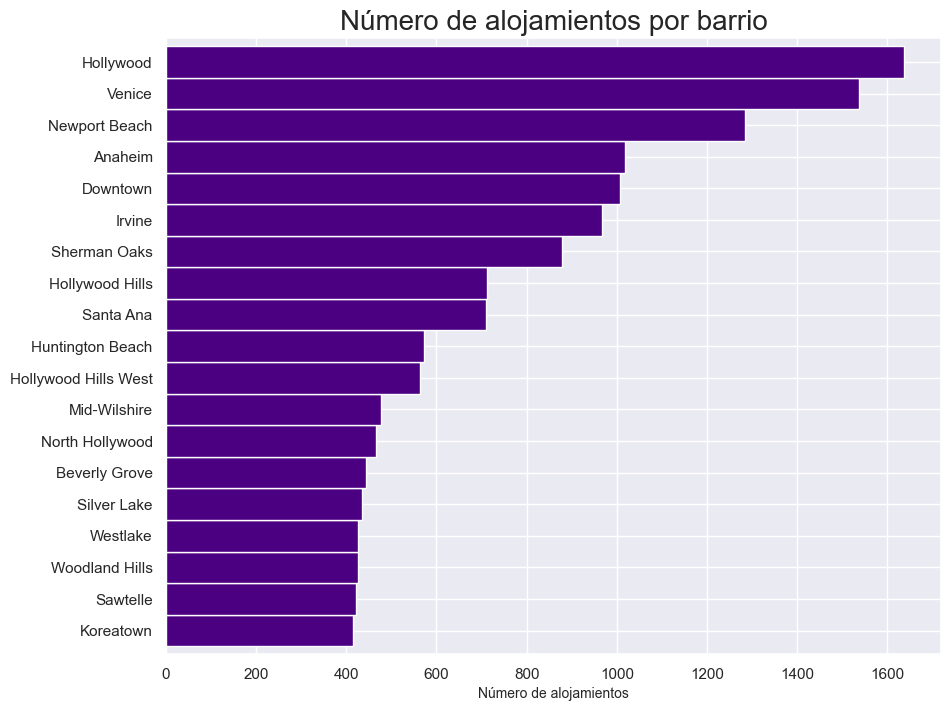

In [44]:
# Busco la cantidad de alojamientos por barrio. Como hay muchos barrios, selecciono aquellos que tienen más de 400 alojamientos.
feq=listings_complete['neighbourhood'].value_counts().sort_values(ascending=True)
feq = feq[feq > 400]
feq.plot.barh(figsize=(10, 8), color='indigo', width=1)
plt.title("Número de alojamientos por barrio", fontsize=20)
plt.xlabel('Número de alojamientos', fontsize=10)
plt.show()

Tanto en esta gráfica como en el mapa posterior se puede apreciar la cantidad de alojamientos disponibles en la ciudad de Los Ángeles por barrio. En la figura, en la que solo se muestran los barrios con más de 400 alojamientos listados, ya que en total hay 154, se observa que hollywood es el barrio con mayor número de ellos.

In [45]:
# Muestro en un mapa los alojamientos en la ciudad de Los Ángeles.
lats = listings_complete['latitude'].tolist()
lons = listings_complete['longitude'].tolist()
locations = list(zip(lats, lons))

map1 = folium.Map(location=[33.9909, -118.2399], zoom_start=9)
FastMarkerCluster(data=locations).add_to(map1)
map1

En este mapa, además de poder verse de forma dinámica e intuitiva la cantidad de alojamientos por barrio, tambien se puede observar una gran cantidad de terreno urbanizado que no se tiene en cuenta en el análisis realizado. Esto es debido a que, en el dataset con el que hemos trabajado, estas zonas eran consideradas como otras ciudades o areas no incorporadas. Para nuestro análisis solo hemos considerado City of Los Ángeles.

## Tipos de alojamientos y propiedad.

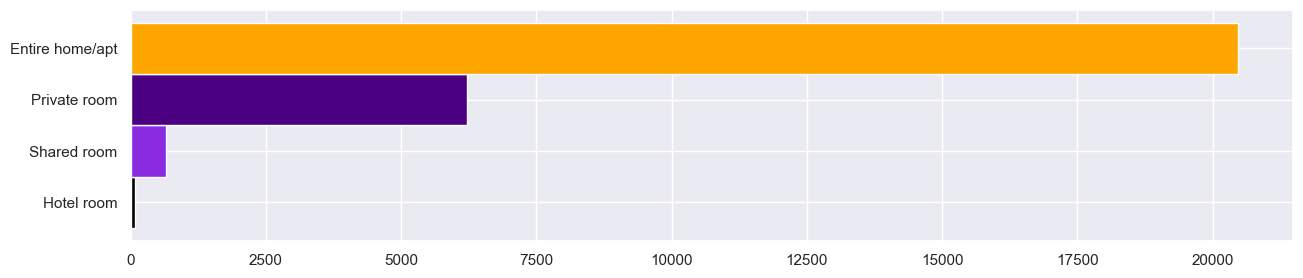

In [46]:
# Tipo de alojamiento que nos podemos encontrar en la ciudad de Los Ángeles.
freq = listings_complete['room_type']. value_counts().sort_values(ascending=True)
freq.plot.barh(figsize=(15, 3), width=1, color = ["black","blueviolet","indigo","orange"])
plt.show()

En este gráfico podemos ver como la mayoría de alojamientos en Los Ángeles son casas/apartamentos completos o habitaciones privadas. Habitaciones compartidas o habitaciones de hotel tienen un lugar residual.

In [47]:
# Tipos de propiedad de los alojamientos. Hay 88 en total.
list_property_type = listings_complete["property_type"].value_counts().head(20)
print(list_property_type)
total_property_type = listings_complete["property_type"].value_counts().count()
print(f"Hay un total de {total_property_type} tipos de propiedad diferentes.")

Entire home                    6799
Entire rental unit             6471
Private room in home           3127
Entire condo                   1706
Private room in rental unit    1364
Entire guesthouse              1339
Entire guest suite              896
Entire villa                    741
Entire townhouse                671
Entire serviced apartment       462
Entire loft                     407
Entire bungalow                 389
Private room in condo           324
Shared room in home             315
Private room in townhouse       252
Private room in guest suite     197
Shared room in rental unit      180
Entire cottage                  174
Room in boutique hotel          174
Room in hotel                   164
Name: property_type, dtype: int64
Hay un total de 88 tipos de propiedad diferentes.


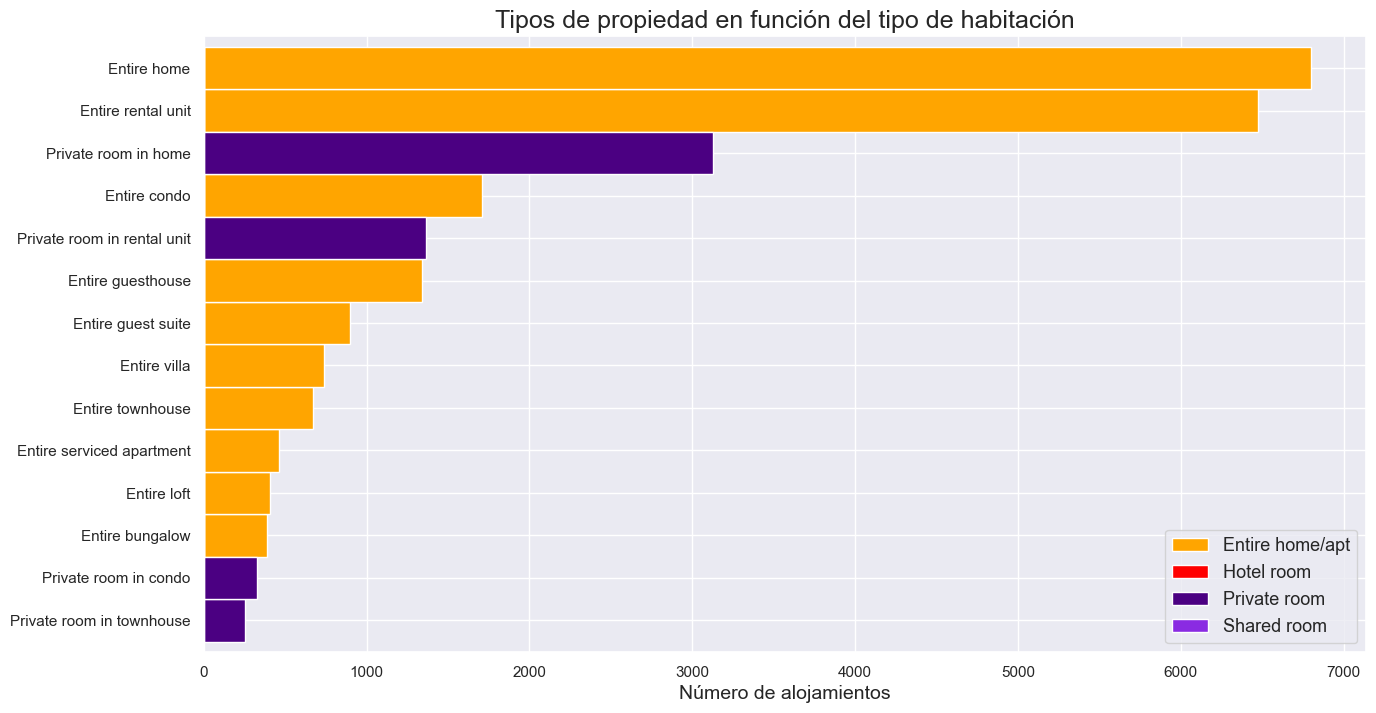

In [48]:
# Tipos de propiedades con cada tipo de habitación.

prop = listings_complete.groupby(['property_type','room_type']).room_type.count()
prop = prop.unstack()
prop['total'] = prop.iloc[:,0:3].sum(axis = 1)
prop = prop.sort_values(by=['total'])
prop = prop[prop['total']>=200]
prop = prop.drop(columns=['total'])

prop.plot(kind='barh',stacked=True, color = ["orange","red", "indigo","blueviolet"],
              linewidth = 1, grid=True, figsize=(15,8), width=1)
plt.title('Tipos de propiedad en función del tipo de habitación', fontsize=18)
plt.xlabel('Número de alojamientos', fontsize=14)
plt.ylabel("")
plt.legend(loc = 4,prop = {"size" : 13})
plt.rc('ytick', labelsize=13)
plt.show()

Es este gráfico se ven los diferentes tipos de propiedades que tiene más de 200 alojamientos. En total hay 88 tipos de propiedades diferentes. Además, podemos ver cuantos tipos de alojamientos tiene cada propiedad.

AirBnb, en ciudad de Los Ángeles, permite listar hoteles, moteles, estructuras residenciales y primeras viviendas (el propietario vive en ella al menos 6 meses al año), entre otras, con la única diferencia de los requerimientos que se les solicitarán para ello, en función de tipo, propiedad, duración del hospedaje, etc. 
Sin embargo, no se permite arrendar segundas viviendas o casas de vacaciones, de forma que para hacerlo habría que fijar un número mínimo de noches de 30, ya que este tipo de arrendamientos no requieren un permiso del ayuntamiento de la ciudad.

## Cantidad de alojados.

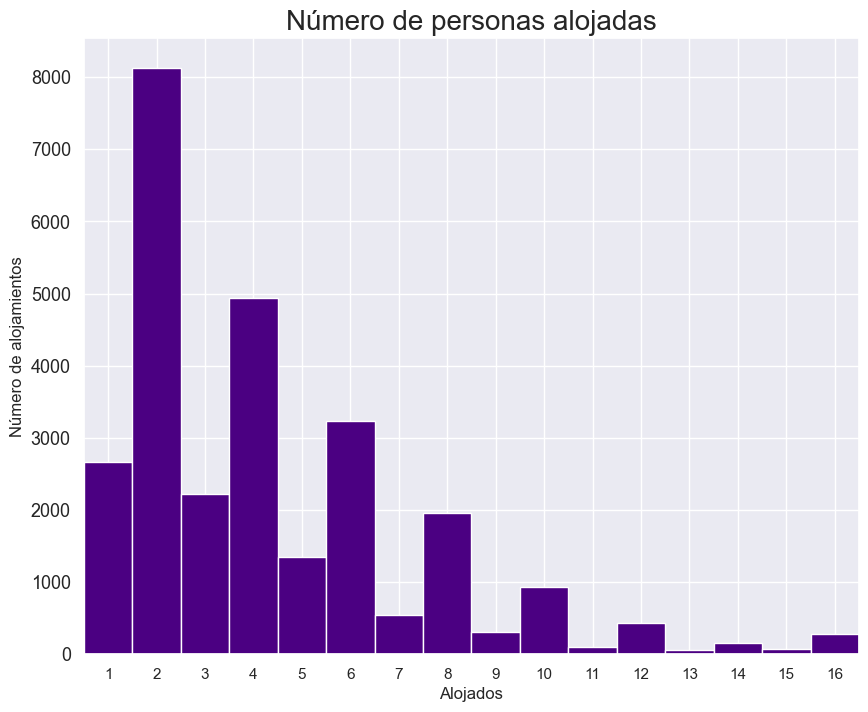

In [49]:
# Estudio el número de alojamientos que permiten un número de alojados determinado.
feq=listings_complete['accommodates'].value_counts().sort_index()
fig = feq.plot.bar(figsize=(10, 8), color='indigo', width=1, rot=0) 
plt.title("Número de personas alojadas", fontsize=20)
plt.ylabel('Número de alojamientos', fontsize=12)
plt.xlabel('Alojados', fontsize=12)
fig.set_xlim([0.5,16.5])
plt.show()

La mayoría de alojamientos listados son para 2 personas, seguido de los alojamientos para 4 personas. Sin embargo, hay listados alojamientos desde una hasta 16 personas.
Tenemos constancia de que la legislación del estado de California solo permite el alquiler para un máximo de 10 personas, por lo que se podría estar incurriendo en una infracción.

## Número de noches.

In [50]:
# Busco el número máximo y mínimo de días que te puedes alojar en Los Ángeles, así como el número medio.

max_noches_media = listings_complete["maximum_nights"].mean()
max_noches_min = listings_complete["maximum_nights"].min()
max_noches_max = listings_complete["maximum_nights"].max()

print(f"El número máximo de noches, en promedio, que te puede alojar en un alojamiento en Los Ángeles es de {max_noches_media:.0f}. El número mínimo es de {max_noches_min} y el número máximo es de {max_noches_max}.")

El número máximo de noches, en promedio, que te puede alojar en un alojamiento en Los Ángeles es de 608. El número mínimo es de 1 y el número máximo es de 99999.


El análisis nos informa de que el número mínimo de noches que te puedes alojar es de una, mientras que el máximo es de 99999. Esto es posible pero hay condiciones que se especifican en la normativa de AirBnb en Los Ángeles. Para un periodo de menos de 30 dias hay que pedir un permiso al ayuntamiento. En caso de ser una segunda vivienda o una estructura residencial, no se podría pedir este permiso. Para 30 o más noches no es obligatorio registrar el alojamiento en AirBnb. El límite establecido por el ayuntamiento está en 120 noches, pero se puede ampliar pidiendo un permiso especial al ayuntamiento.

En este punto es apropiado preguntarse cuantos alojamientos requieren un licencia. Para ello se calculan los que alojan por un máximo menor de 30 y por un máximo mayor que 120.

In [51]:
# Obtengo el número de alojamientos que requerirían algún tipo de licencia.
menosde = len(listings_complete[listings_complete["maximum_nights"]<30])
masde = len(listings_complete[listings_complete["maximum_nights"]>120])
totalde = len(listings_complete)
print(f"Un total de {menosde} alojamientos permiten arrendar menos de 30 días.")
print(f"Un total de {masde} alojamientos permiten arrendar más de 120 días.")
print(f"Esto supone que un total de {menosde+masde}, es decir, el {(menosde+masde)/totalde*100:.2f}% de los alojamientos requieren licencia.")

Un total de 2124 alojamientos permiten arrendar menos de 30 días.
Un total de 20199 alojamientos permiten arrendar más de 120 días.
Esto supone que un total de 22323, es decir, el 81.50% de los alojamientos requieren licencia.


Una vez realizado este cálculo, se puede observar que un 81% de los alojamientos requieren de una licencia para operar. Sin embargo, se recordará que el 63% de los alojamientos aportaban datos nulos en el dataset. Se sugiere investigar si estos nulos se deben a que no se introdujo el dato o a la falta de licencia.

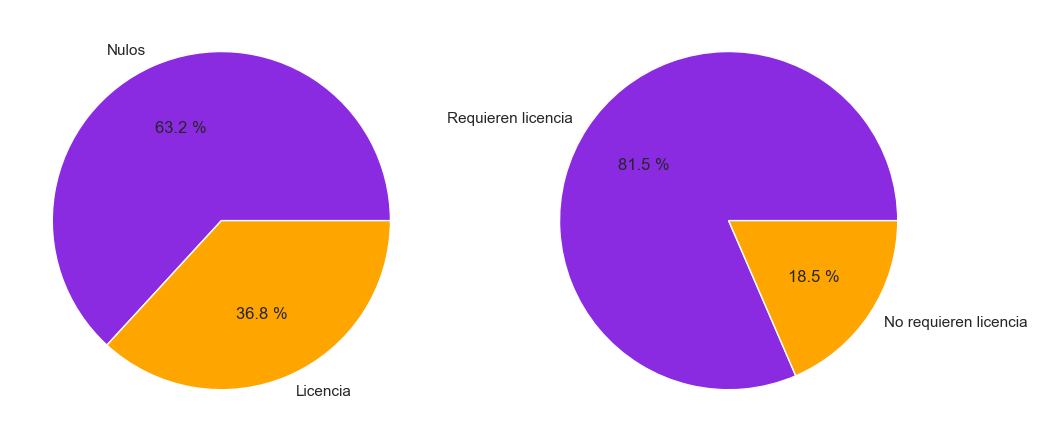

In [52]:
# Grafico la cantidad de licencias faltantes y la cantidad de alojamientos que requiren licencia.
licencia_nulos = listings_complete["license"].isnull().value_counts()
necesidad_licencia = (menosde+masde)/totalde*100
fig, axes = plt.subplots(1, 2, figsize=(12,7))
labels1 = ["Nulos", "Licencia"]
labels2 = ["Requieren licencia", "No requieren licencia"]
axes[0].pie(licencia_nulos, colors=["blueviolet","orange"], labels=labels1, autopct = '%0.1f %%')
axes[1].pie([necesidad_licencia,100-necesidad_licencia], colors=["blueviolet","orange"], labels = labels2, autopct = '%0.1f %%');

## Propiedad

No hemos encontrado información en cuanto a normativas que regulen el porcentaje de propiedad que pueda ser arrendado. Si hemos descubierto que, propiedades que tengan más de una habitación en alquiler, aunque puedan tenerlas alquiladas al mismo tiempo, no pueden tener más de una reserva activa a la vez. No disponemos de información de reservas en los dataset que permita comprobar esto, así que nos conformaremos con comprobar anfitriones y cantidad de alojamientos en alquiler.

In [53]:
# Obtengo las habitaciones privadas que tiene cada anfitrión.
private = listings_complete[listings_complete['room_type'] == "Private room"]
host_private = private.groupby(['host_id', 'host_name']).size().reset_index(name='private_rooms').sort_values(by=['private_rooms'], ascending=False)
host_private.head(10)

host_id              host_name  private_rooms
2394  144214204           Jino & Scott            342
3312  401130632         Scott And Jino             94
2576  174792040  RoomPicks By Victoria             57
3393  430751743                    Fen             51
3178  340907169                   June             36
3486  464261743                   Jino             34
3420  439929628                  Ethan             33
359     4780152                   Moon             31
756    14936368                   Andy             28
3364  423770662                   Kieu             25

Se comprueba que Jino y Scott, de diferentes formas, tanto juntos como separadas, poseen multitud de propiedades, pero no hay información para determinar si hacen reservas de forma simultanea. Sería obligación de la autoridad competente investigar esto.
Tampoco hemos encontrado ninguna norma que prohiba las actividades de alojamiento profesional, de modo que un anfitrión podría arrendar los alojamientos que quiera, siempre que tenga en cuenta que, si es segunda residencia o estructura residencial, el alquiler debe ser por más de 30 días.

In [54]:
# Obtengo información de los diferentes anfitriones, ordenados por la cantidad de alojamientos listados.
freq = listings_complete.groupby(['host_id', 'host_name']).size().reset_index(name='num_host_listings')
freq = freq.sort_values(by=['num_host_listings'], ascending=False)
freq = freq[freq['num_host_listings']  >= 20]
freq

host_id                         host_name  num_host_listings
8769   107434423                        Blueground                545
9636   144214204                      Jino & Scott                344
4304    22131547                  Beachview Realty                126
13649  429429981                 Vacasa California                119
6385    47662934  Tower 17 Properties & Management                118
...          ...                               ...                ...
14407  474535288                              Seba                 20
14312  468930663                          Danielle                 20
8422    96220702                              Juan                 20
10870  209743834                             Sukho                 20
11682  263502162                           Landing                 20

[102 rows x 3 columns]

## Precio por barrios.

Buscamos los barrios más caros y los más baratos, tomando como referencia los alojamientos que alquilan para dos personas, que, como hemos visto más arriba, es lo más común.

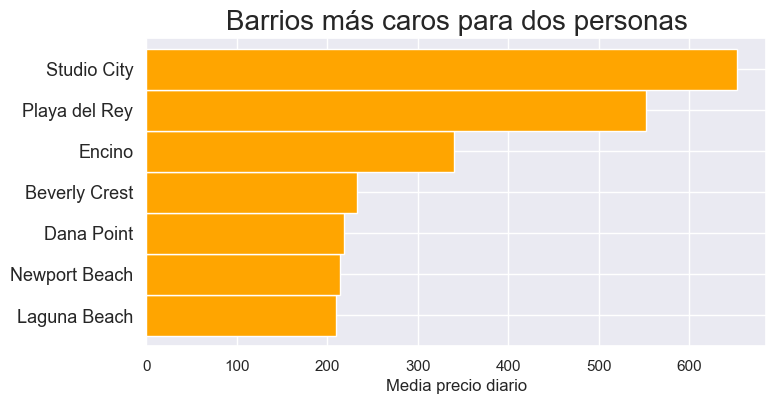

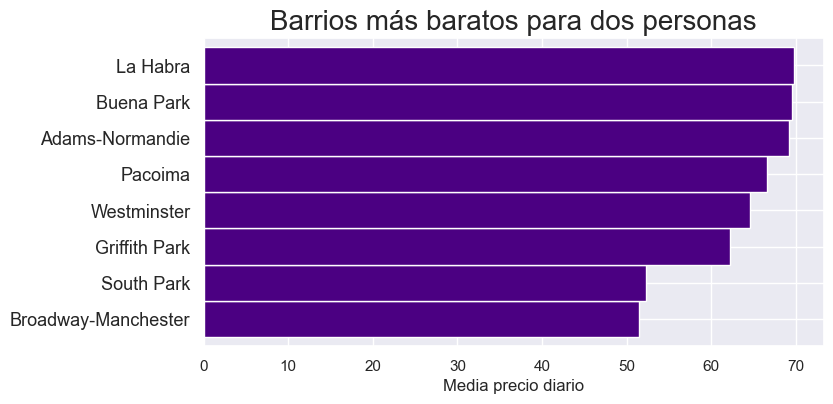

In [55]:
# Busco los barrios más caros para dos personas.
feq1 = listings_complete[listings_complete['accommodates']==2]
feq1 = feq1.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq1 = feq1[feq1 > 200]
feq1.plot.barh(figsize=(8, 4), color='orange', width=1)
plt.title("Barrios más caros para dos personas", fontsize=20)
plt.xlabel('Media precio diario', fontsize=12)
plt.ylabel("")
plt.show()

# Busco los barrios más baratos para dos personas.
feq2 = listings_complete[listings_complete['accommodates']==2]
feq2 = feq2.groupby('neighbourhood')['price'].mean().sort_values(ascending=True)
feq2 = feq2[feq2 < 70]
feq2.plot.barh(figsize=(8, 4), color='indigo', width=1)
plt.title("Barrios más baratos para dos personas", fontsize=20)
plt.xlabel('Media precio diario', fontsize=12)
plt.ylabel("")
plt.show()



## Valoraciones.

En este apartado se han calculado las notas medias de los diferentes barrios, en cuanto a localización del alojamiento, a limpieza, relación calidad precio y nota del arrendador, los campos que he considerado más importantes de las opciones del dataset. Además, solo se han tenido en cuenta para las medias aquellos alojamientos con más de 10 valoraciones.

Como se puede observar, hay bastantes coincidencias entre los barrios con mejor valoración de localización, limpieza, anfitrión o relación calidad precio. Más llamativo es, si cabe, que salvo Newport Beach, los barrios más caros para dos personas no aparecen entre los más valorados en ninguno de los casos estudiados. Si bien es cierto, en Los Ángeles hay muchos barrios y se están mostrando pocos para no saturar de información. Es presuponible que de seleccionar una lista con más barrios caros, más de ellos aparecerían entre los más valorados. Tambien es reseñable como La Habra, uno de los barrios más baratos, es de los que tienen mejor valoración en cuantro a relación calidad precio.

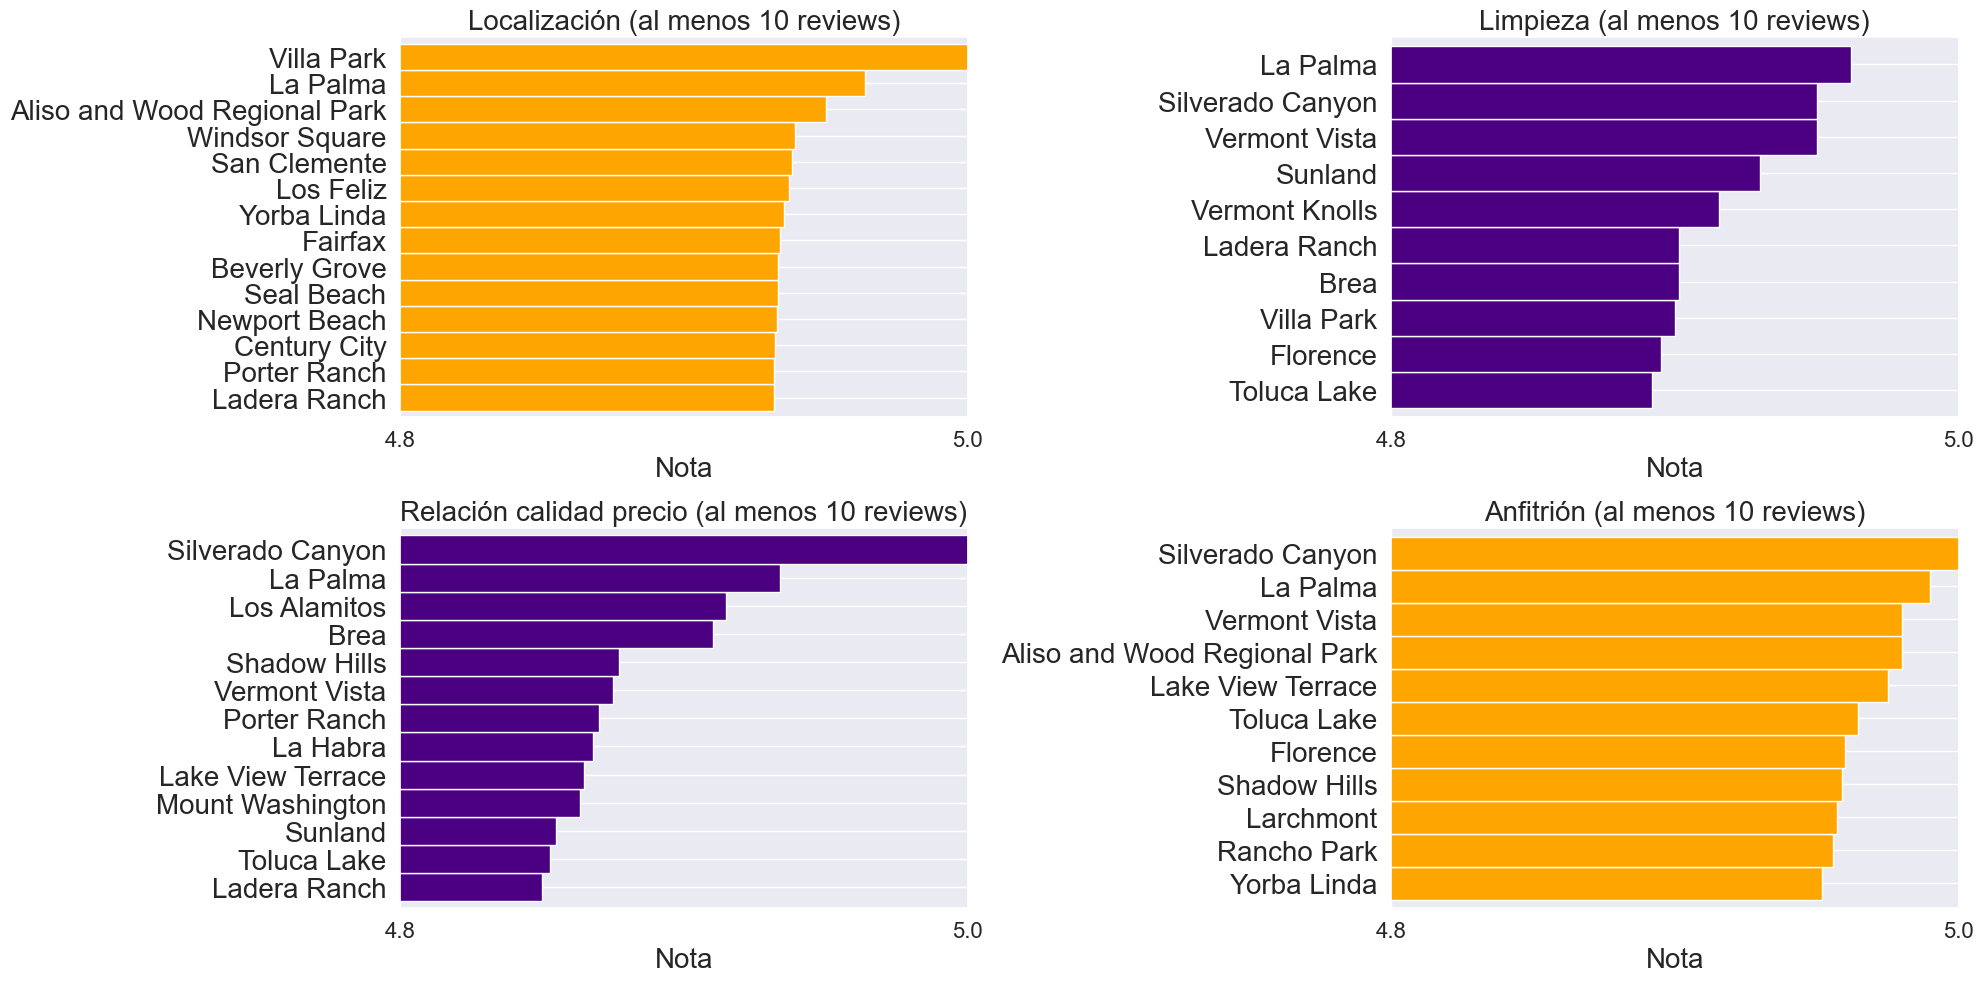

In [56]:
# Obtengo la nota media general y la nota media de la limpieza de los barrios con al menos 10 alojamientos.
fig = plt.figure(figsize=(20,10))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(221)
feq = listings_complete[listings_complete['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_location'].mean().sort_values(ascending=True)
feq1 = feq1[feq1 > 4.93]
ax1=feq1.plot.barh(color='orange', width=1)
plt.title("Localización (al menos 10 reviews)", fontsize=20)
plt.xlabel('Nota', fontsize=20)
plt.ylabel("")
ax1.set_xticks([4.8,5])
ax1.set_xlim([4.8,5])

ax2 = fig.add_subplot(222)
feq = listings_complete[listings_complete['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_cleanliness'].mean().sort_values(ascending=True)
feq1 = feq1[feq1 > 4.88]
ax2=feq1.plot.barh(color='indigo', width=1)
plt.title("Limpieza (al menos 10 reviews)", fontsize=20)
plt.xlabel('Nota', fontsize=20)
plt.ylabel("")
ax2.set_xticks([4.8,5])
ax2.set_xlim([4.8,5])

ax1 = fig.add_subplot(223)
feq = listings_complete[listings_complete['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_value'].mean().sort_values(ascending=True)
feq1 = feq1[feq1 > 4.85]
ax1=feq1.plot.barh(color='indigo', width=1)
plt.title("Relación calidad precio (al menos 10 reviews)", fontsize=20)
plt.xlabel('Nota', fontsize=20)
plt.ylabel("")
ax1.set_xticks([4.8,5])
ax1.set_xlim([4.8,5])

ax2 = fig.add_subplot(224)
feq = listings_complete[listings_complete['number_of_reviews']>=10]
feq1 = feq.groupby('neighbourhood')['review_scores_communication'].mean().sort_values(ascending=True)
feq1 = feq1[feq1 > 4.95]
ax2=feq1.plot.barh(color='orange', width=1)
plt.title("Anfitrión (al menos 10 reviews)", fontsize=20)
plt.xlabel('Nota', fontsize=20)
plt.ylabel("")
ax2.set_xticks([4.8,5])
ax2.set_xlim([4.8,5])

plt.tight_layout()
plt.show()


In [57]:
# Gráfico de cantidad de puntuaciones por barrio y nota.
fig = px.scatter(listings_complete, 
            x = "review_scores_value", 
            y = "neighbourhood", 
            color = "review_scores_cleanliness", 
            title = "Cantidad notas barrio y limpieza")
fig.update_layout(width=1200, height=600,
        yaxis = dict(title = "Barrio",tickfont = dict(size = 10)),
        xaxis = dict(title = "Nota general"))


Es interesante observar que una inmesa mayoría de las notas (más del 96%, como se ve a continuación) son de más de un cuatro y que los barrios con menos nota general tambien tienen poco nota de limpieza. Habría que valorar la importacia que se le dan a las notas viendo lo ajustadas que están las notas altas. Parece claro que una nota baja justifica una decisión con respecto al alojamiento que la ostenta, pero cuando son altas hay obligan a decidir con mayor precisión y riesgo.

In [58]:
# Calculo el porcentaje de puntuaciones mayores de cuatro.
per_pun = len(listings_complete[listings_complete["review_scores_value"]>=4])/len(listings_complete["review_scores_value"])*100
print(f"El porcentaje de puntuaciones mayores de 4 es del {per_pun:.2f}%")

El porcentaje de puntuaciones mayores de 4 es del 96.81%


## Anfitriones.

Los Superhost están un paso por delante de los anfitriones normales, alquilan más y en mejores condiciones que los demás (salvo por el precio), lo que los hace merecedores de mejores reseñas. Son los hospedadores que todos querríamos tener.
Por eso, en este paso se calculará la cantidad de super anfitriones de la ciudad de Los Ángeles.

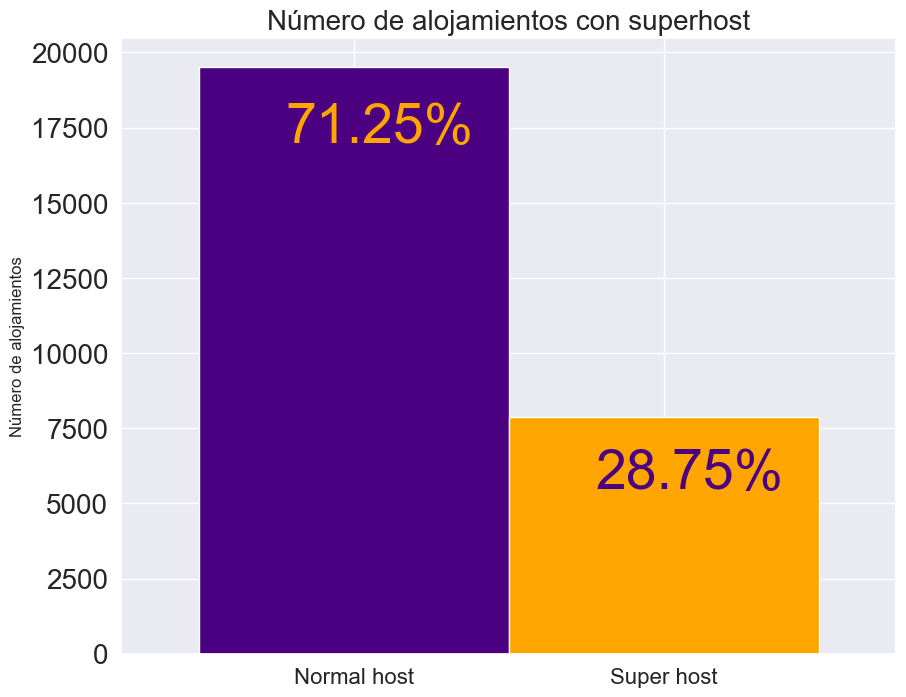

In [59]:
# Calculo el porcentaje de superhost.
listings_complete["host_is_superhost"] = listings_complete["host_is_superhost"].replace({"t": "Super host", "f": "Normal host"})
True_per = len(listings_complete[listings_complete["host_is_superhost"]=="Super host"])/len(listings_complete)*100
False_per = len(listings_complete[listings_complete["host_is_superhost"]=="Normal host"])/len(listings_complete)*100
feq=listings_complete['host_is_superhost'].value_counts()
feq.plot.bar(figsize=(10, 8), width=1, rot=0, color = ("indigo", "orange"))
plt.title("Número de alojamientos con superhost", fontsize=20)
plt.ylabel('Número de alojamientos', fontsize=12)
plt.text(-0.22, 17000, f"{False_per:.2f}%", fontsize=40, color="orange") 
plt.text(0.78, 5500, f"{True_per:.2f}%", fontsize=40, color="indigo")
plt.show()

En los siguientes gráficos se pueden ver tanto el ratio de respuesta como el tiempo de las mismas. Se aprecia que la mayoría de las consultas son resueltas e, igualmente, que la mayoría de ellas son atendidas en menos de una hora. Es interesante tener en cuenta estos parametros, aparte de que el hospedador pueda ser un superhost, para seleccionar alojamiento, pero hay otro tipo de aspectos, en ocasiones no tan ponderables, que tambien es interesante tener en cuenta, como disponibilidad de medidas de seguridad.

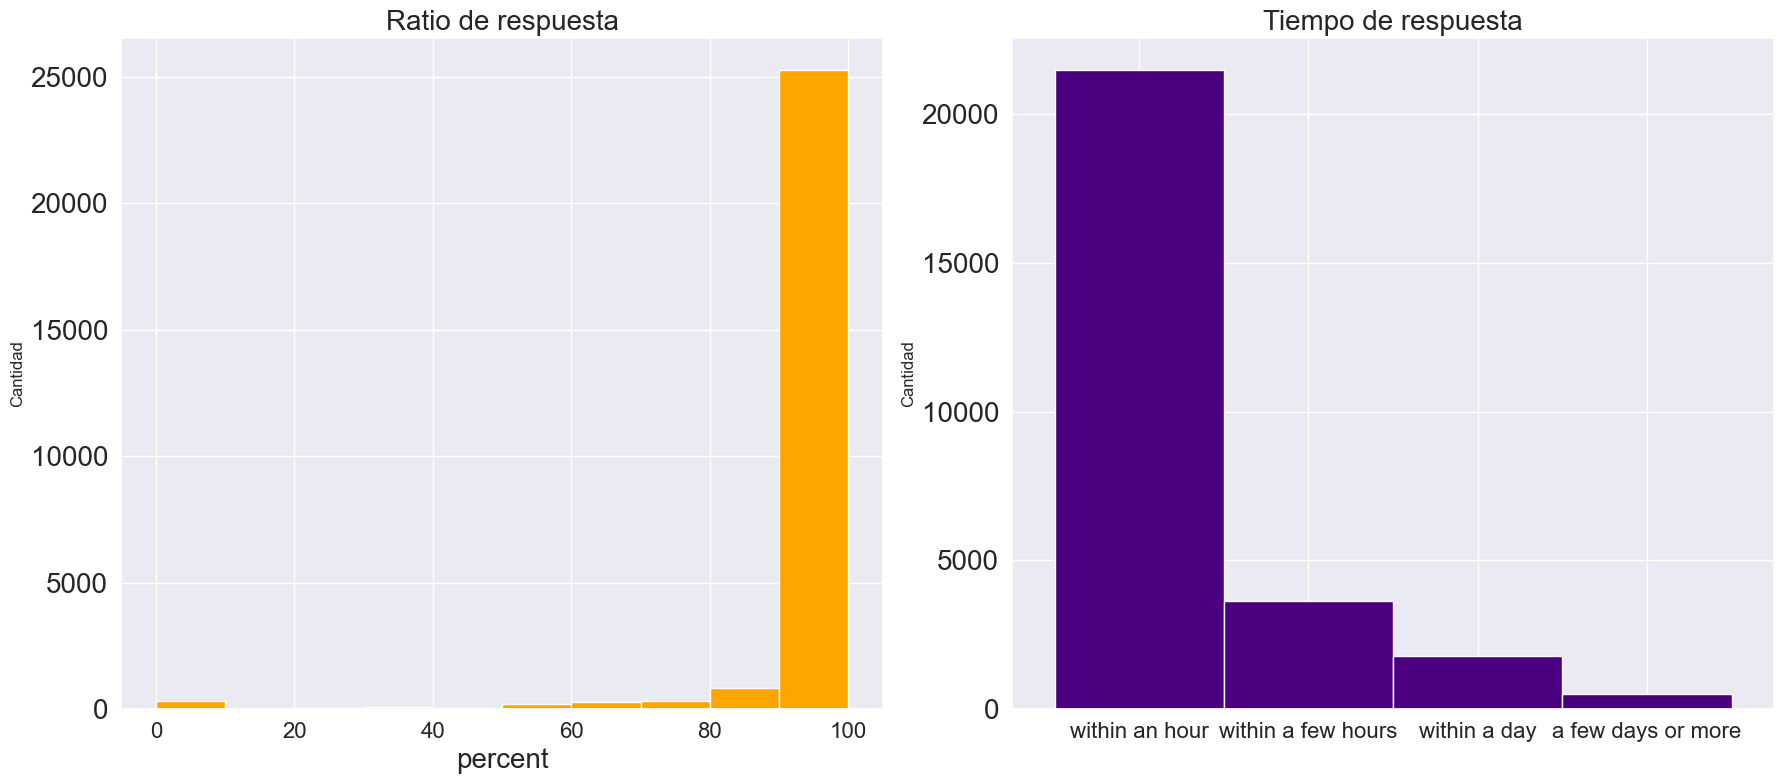

In [60]:
fig = plt.figure(figsize=(18,8))
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=20)

ax1 = fig.add_subplot(121)
feq1 = listings_complete['host_response_rate']
ax1=feq1.plot.hist(color='orange')
plt.title("Ratio de respuesta", fontsize=20)
plt.ylabel("Cantidad")
plt.xlabel("percent", fontsize=20)

ax2 = fig.add_subplot(122)
feq2 = listings_complete['host_response_time'].value_counts()
ax2=feq2.plot.bar(color='indigo', width=1, rot = 0)
plt.title("Tiempo de respuesta", fontsize=20)
plt.ylabel("Cantidad")

plt.tight_layout()
plt.show()

## Disponibilidad a lo largo del año.

Este dataframe nos permite ver la cantidad de alojamientos disponibles por fecha. Lo fusionaré con la columna accommodates del dataframe listing_complete para poder calcular el precio medio para dos inquilinos a lo largo del año.

In [61]:
# Observo el dataframe calendario.

calendar = calendar[calendar["date"] > '2023-01-01']

In [62]:
# Introduzco la columna accommodates.
listings_complete.index.name = "listing_id"
calendar_fusion = pd.merge(calendar, listings_complete[['accommodates']], on = "listing_id", how = "left")
calendar_fusion

date available  price  adjusted_price  minimum_nights  \
listing_id                                                               
51307      2023-01-02         f   75.0            75.0            30.0   
51307      2023-01-03         f   75.0            75.0            30.0   
51307      2023-01-04         f   75.0            75.0            30.0   
51307      2023-01-05         f   75.0            75.0            30.0   
51307      2023-01-06         f   75.0            75.0            30.0   
...               ...       ...    ...             ...             ...   
27901174   2023-09-05         f  170.0           170.0             1.0   
27901174   2023-09-06         f  170.0           170.0             1.0   
27901174   2023-09-07         f  170.0           170.0             1.0   
27901174   2023-09-08         f  174.0           174.0             1.0   
27901174   2023-09-09         f  174.0           174.0             1.0   

            maximum_nights  accommodates  
listing_id                                
51307                365.0           2.0  
51307                365.0           2.0  
51307                365.0           2.0  
51307                365.0           2.0  
51307                365.0           2.0  
...                    ...           ...  
27901174            1125.0           4.0  
27901174            1125.0           4.0  
27901174            1125.0           4.0  
27901174            1125.0           4.0  
27901174            1125.0           4.0  

[11484513 rows x 7 columns]

In [63]:
# Grafico la cantidad de alojamientos disponibles a lo largo del año.
sum_available = calendar_fusion[calendar_fusion["available"] == "t"].groupby(['date']).size().to_frame(name= 'available').reset_index()
sum_available['weekday'] = sum_available['date'].dt.day_name()
sum_available = sum_available.set_index('date')

sum_available.iplot(y='available', mode = 'lines', xTitle = 'Fecha', yTitle = 'número de alojamientos disponibles',
                   text='weekday', title = 'Número de alojamientos disponibles por fecha')

Como se aprecia en este gráfico, con datos actualizados el 6 de diciembre de 2022, la disponibilidad en los primeros meses del año es mayor que en los siguientes. En el caso de Los Ángeles puede influir la obligatoriedad de solo poder hacer una reserva a la vez en alojamientos con más de una habitación disponible. También a que los anfritriones prefieren alquilar más al corto plazo y aún no tienen abiertas reservas para esas fechas, para que no les solapen reservas más próximas.

## Precio medio por día.

En el siguiente gráfico se aprecian los precios medios diarios para dos personas. Se puede ver como en los primeros meses del año el precio es más reducido y aumenta según va avanzando el calendario, siendo lo más elevado de lo que tenemos constancia los meses de verano. En el gráfico se aprecia la variabilidad semanal y cierta estabilidad por grupos de meses. Esto último se puede deber a una falta de actualización. Tambien se aprecia como en las fechas de semana santa los precios son ligeramente superiores.

In [64]:
# Grafico el precio medio diario para dos personas.
average_price = calendar_fusion[(calendar_fusion["available"] == "t") & (calendar_fusion["accommodates"] == 2)].groupby(['date']).mean().astype(np.int64).reset_index()
average_price['weekday'] = average_price['date'].dt.day_name()
average_price = average_price.set_index('date')

average_price.iplot(y='price', mode='lines', xTitle='Fecha', yTitle='Precio',
    text='weekday', title='Precio medio para dos personas por día.')

## Reseñas.

In [65]:
# Uno varias columnas de listings_complete con el dataframe reviews_detail.
reviews_details = pd.merge(reviews_details, listings_complete[['host_id', 'host_name', 'name']], on = "listing_id", how = "left")
reviews_details = reviews_details.set_index('id')
reviews_details = reviews_details[['listing_id', 'name', 'host_id', 'host_name', 'date', 'reviewer_id', 'reviewer_name', 'comments']]
reviews_details.head()

listing_id                                               name  \
id                                                                         
449036            109                                                NaN   
74506539          109                                                NaN   
13994902         2708  Runyon Canyon | Beau Furn Mirror Mini-Suite Fi...   
988343         183319                  Panoramic Ocean View Venice Beach   
184002210      183319                  Panoramic Ocean View Venice Beach   

            host_id  host_name       date  reviewer_id reviewer_name  \
id                                                                     
449036          NaN        NaN 2011-08-15       927861         Edwin   
74506539        NaN        NaN 2016-05-15     22509885          Jenn   
13994902     3008.0      Chas. 2014-06-09     10905424       Kuberan   
988343     867995.0  Barbara X 2012-03-11      1219947     Gabriella   
184002210  867995.0  Barbara X 2017-08-18     70046039           Yan   

                                                    comments  
id                                                            
449036     The host canceled my reservation the day befor...  
74506539   Me and two friends stayed for four and a half ...  
13994902   i had a wonderful stay. Everything from start ...  
988343     very nice and cozy apartment, well located in ...  
184002210  We loved the experience. The location couldn't...

In [71]:
# Obtengo a los hospedadores con más reseñas.
host_reviews = reviews_details.groupby(['host_id', 'host_name']).size().sort_values(ascending=False).to_frame(name = "number_of_reviews")
host_reviews.head(10)

number_of_reviews
host_id     host_name                      
43215337.0  David                      6235
2622454.0   Mary                       5161
2582449.0   Andy                       3572
18274664.0  Funtierland                2732
33867398.0  Leo                        2603
47063020.0  Priya                      2523
161489684.0 The Freehand               2250
157215163.0 Christopher                2249
35786994.0  Kevin                      2115
21900104.0  Mike                       1981

A partir de este momento se procesarán los comentarios para crear un wordcloud. Para ellos se eliminaran símbolos y palabras poco útiles para el análisis.

In [67]:
# Proceso los comentarios.
reviews_details = reviews_details[reviews_details['comments'].notnull()]

## Elimino elementos no útiles.
reviews_details['comments'] = reviews_details['comments'].str.replace('\d+', '') 
reviews_details['comments'] = reviews_details['comments'].str.lower()
reviews_details['comments'] = reviews_details['comments'].str.replace('\r\n', "")
reviews_details['comments'] = reviews_details['comments'].str.replace('br', '')
stop_english = stopwords.words("english")# Elimino stopwords, para lo que anteriormente importe la librería nltk.
reviews_details['comments'] = reviews_details['comments'].apply(lambda x: " ".join([i for i in x.split() 
                                                      if i not in (stop_english)]))
reviews_details['comments'] = reviews_details['comments'].str.replace('[^\w\s]'," ")
reviews_details['comments'] = reviews_details['comments'].str.replace('\s+', ' ')

reviews_details["comments"].values[1] 

'two friends stayed four half months great place stay apartment comfortable really enjoyed park running path across street downside within walking distance restaurants bars coffee shops short drive away overall great stay '

In [68]:
# Hago el conteo de las palabras que más se repiten en los comentarios.
texts = reviews_details["comments"].tolist()

vec = CountVectorizer().fit(texts)
bag_of_words = vec.transform(texts)
sum_words = bag_of_words.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]

cvec_df = pd.DataFrame.from_records(words_freq, columns= ['words', 'counts']).sort_values(by="counts", ascending=False)
cvec_df.head(10)

words  counts
11        great  893761
12        place  839934
13         stay  774539
109       clean  462991
52     location  461279
269       would  353735
44         nice  340338
0          host  339010
66        house  315292
36   everything  286775

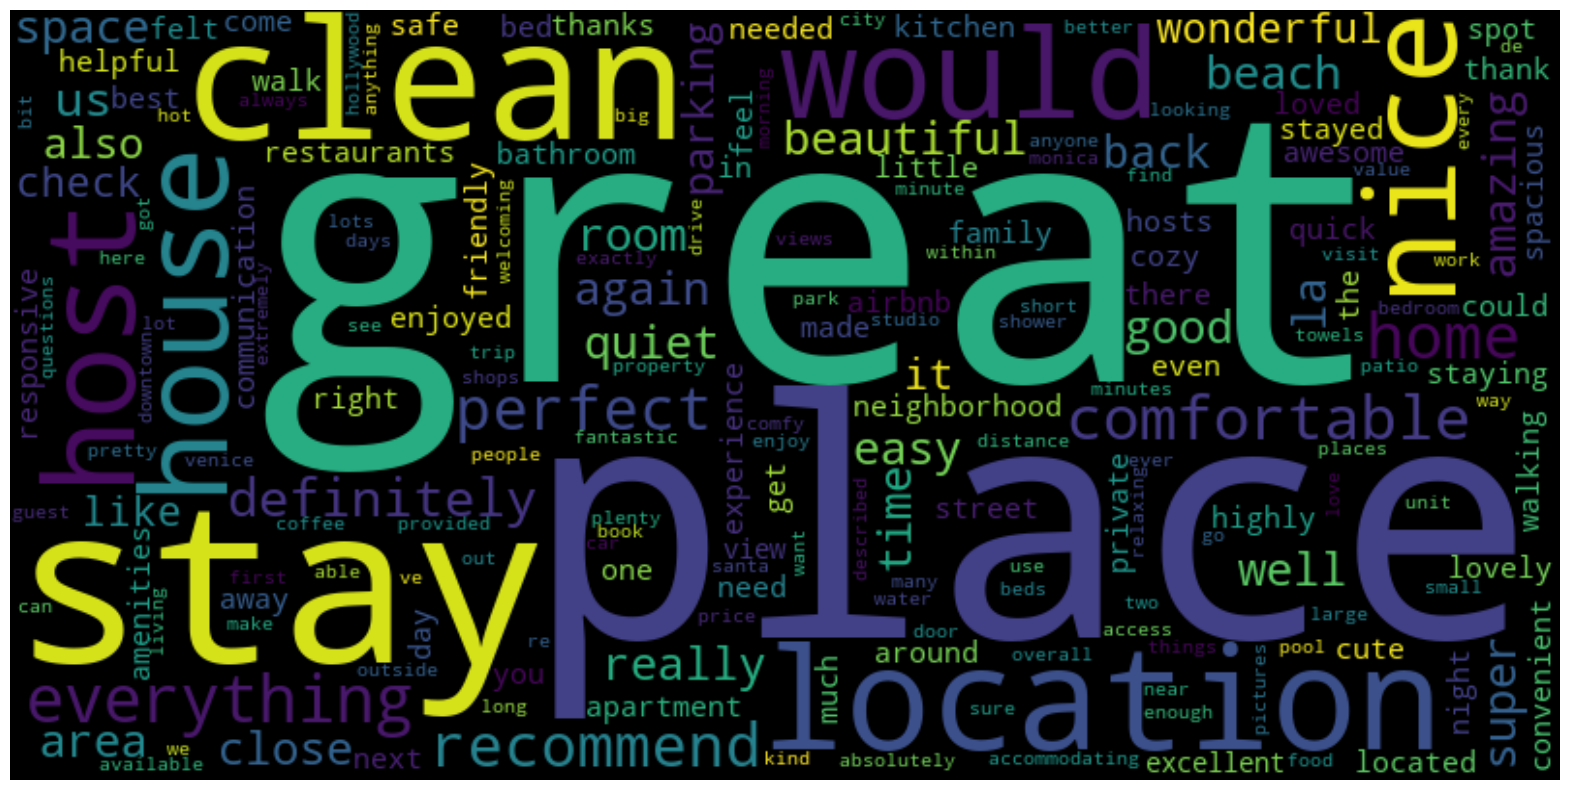

In [69]:
# Realizo el wordcloud con las palabras que más se repiten.
cvec_dict = dict(zip(cvec_df["words"], cvec_df.counts))

wordcloud = WordCloud(width=800, height=400)
wordcloud.generate_from_frequencies(frequencies=cvec_dict)
plt.figure( figsize=(20,10) )
plt.imshow(wordcloud, interpolation= "bilinear", cmap="Reds", alpha = 1, origin ='upper', aspect="auto")
plt.axis("off")
plt.show()

## Bibliografía.

[Normativa AirBnb Los Ángeles](https://www.airbnb.es/help/article/864)<br>
[Leyes de alquiler de vacaciones de California: Airbnb](https://eslegal.info/estados-unidos/leyes-de-alquiler-de-vacaciones-de-california-airbnb-laws-regulaciones/)<br>
[Many Airbnb rentals in U.S. cities lack fire safety features. Cortesía Roberto.](https://www.reuters.com/article/us-health-travel-airbnb-safety-idUSKBN1I82JN)<br>
[Airbnb & Short-Term Rental Rules and Regulations in California. Cortesía Roberto.](https://www.lodgify.com/guides/short-term-rental-rules-california/)